# Demo 1: LLM-assisted data-mining from the literature

In [2]:
import os
import pandas as pd
from openai import OpenAI
import cv2
from matplotlib import pyplot as plt
from PIL import Image
from models import llm_lit_assistant, decimer_ai
from utils import plotting

C:/Users/kvriz/.data/DECIMER-V2\DECIMER_model
Instructions for updating:
Use fn_output_signature instead


In [69]:
openai_api_key = os.environ.get("OPENAI_API_KEY", "")
model_name = 'gpt-4-turbo-preview'

lit_folder_path = './datasets/ecps_text'

# excluded from public repo
file_ecps_synthesis_paragraphs = 'datasets/openaccess_ecps_synthesis_paragraphs.csv'

In [35]:
client = OpenAI(api_key=openai_api_key)

models = [m.id for m in client.models.list() if m.id.startswith('gpt-')]
if model_name not in models:
    print(f"Available models:\n  {'\n  '.join(models)}")

Available models:
  gpt-4o-mini
  gpt-4o-mini-2024-07-18
  gpt-3.5-turbo-instruct
  gpt-3.5-turbo-0125
  gpt-3.5-turbo
  gpt-3.5-turbo-16k
  gpt-3.5-turbo-1106
  gpt-3.5-turbo-instruct-0914


## * Collection of literature papers in text format

The example literature text in this demo is extracted from the HTML page of an open-access journal.

In [36]:
# process html/pdf and output to txt_file_path in text format

# TODO

## * Data-mining from synthesis paragraphs

In [ ]:
# Extract synthesis paragraphs
ecps_synthesis = llm_lit_assistant.extract_synthesis_paragraph(
    lit_folder_path, client, model_name, retry=1
)
print(ecps_synthesis)

# extract chemicals from synthesis paragraphs
ecps_chemicals = llm_lit_assistant.extract_chemical_elements(
    ecps_synthesis, client, model_name, retry=1
)
print(ecps_chemicals)

# Statistics of the extracted chemicals
ecps_statistics = llm_lit_assistant.extract_chemical_statistics(
    ecps_chemicals, client, model_name, retry=1
)
print(ecps_statistics)

### Expected output

⚠️ Reproducibility disclaimer: The output is dependent on the GPT version. Even for a given model_name, the model might be retrained overtime.

In [70]:
ecps_synthesis = pd.read_csv(file_ecps_synthesis_paragraphs, encoding='latin1')
ecps_synthesis

,file_name,synthesis_paragraphs
0,nmat2272.txt,"Here, we report on the synthesis and polymeriz..."


## * Plotting the occurence of chemicals

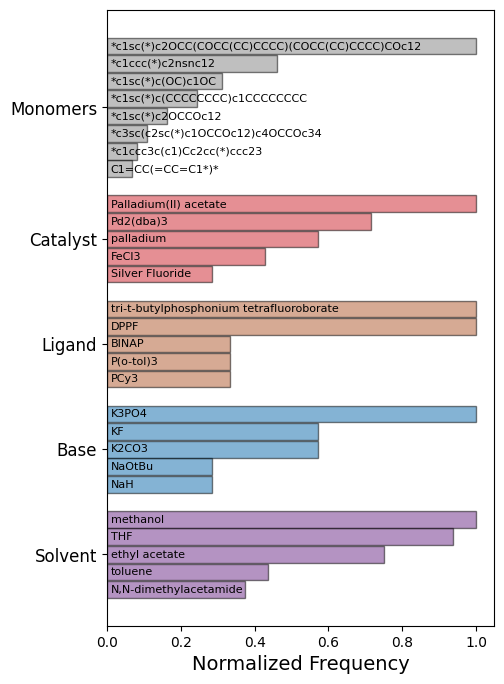

In [65]:
# dictionary with the main monomers counts found from the literature database

ecps_statistics = {
    "Solvent": {
        "N,N-dimethylacetamide": 6,
        "methanol": 16,
        "acetone": 5,
        "THF": 15,
        "toluene": 7,
        "propylene carbonate": 3,
        "ethanol": 1,
        "isopropanol": 1,
        "DMF": 5,
        "DMSO": 4,
        "dioxane": 2,
        "ethyl acetate": 12,
        "1-hexanol": 1,
        "CH3CN": 1,
    },
    "Base": {
        "KOH": 1,
        "K2CO3": 4,
        "K3PO4": 7,
        "KF": 4,
        "NaH": 2,
        "NEt3": 1,
        "NaOtBu": 2,
    },
    "Ligand": {
        "PCy3": 1,
        "DPPF": 3,
        "tri-t-butylphosphonium tetrafluoroborate": 3,
        "P(o-tol)3": 1,
        "BINAP": 1,
    },
    "Catalyst": {
        "FeCl3": 3,
        "palladium": 4,
        "Pd2(dba)3": 5,
        "Pd[P(tBu)3]2": 1,
        "CuI": 1,
        "AgF": 1,
        "Silver Fluoride": 2,
        "Palladium(II) acetate": 7,
    },
    "Monomers": {
        "*c1sc(*)c2OCC(COCC(CC)CCCC)(COCC(CC)CCCC)COc12": 74,
        "*c1ccc(*)c2nsnc12": 34,
        "*c1sc(*)c(OC)c1OC": 23,
        "*c1sc(*)c(CCCCCCCC)c1CCCCCCCC": 18,
        "*c1sc(*)c2OCCOc12": 12,
        "*c3sc(c2sc(*)c1OCCOc12)c4OCCOc34": 8,
        "*c1ccc3c(c1)Cc2cc(*)ccc23": 6,
        "C1=CC(=CC=C1*)*": 5,
    },
}

colors = {
    'Solvent': '#6B2986',
    'Base': '#0A69AB',
    'Ligand': '#AF562B',
    'Catalyst': '#CC212A',
    'Monomers': 'gray',
}

plotting.create_horizontal_bar_chart_with_annotations(ecps_statistics, colors)

## * Extracting molecular structure information


In [ ]:
image_path = "datasets/monomer_structure_example\images_large_ma-2016-01763s_0008.jpeg"
save_path =  "datasets/monomer_structure_example"
segments, bboxes, page = decimer_ai.structure_image_segment(image_path)

name_boxes, polymer_info  = decimer_ai.ocrc_polymer_names(image_path)

modified_page, decimer_ai_boxes, ocr_boxes = decimer_ai.visualize_structure_boxes(segments, bboxes, page, name_boxes)
matched_indices = decimer_ai.match_boxes(ocr_boxes, decimer_ai_boxes)
print('matched_indices', matched_indices)
smiles_list = []
polymer_name = []
for i, index in enumerate(matched_indices):
    name = polymer_info[i]
    print(f"Polymer {name}")# matches with molecular image box {decimer_ai_boxes[index]}")
    polymer_name.append(name)
    image_array = segments[index]
    image = Image.fromarray(image_array)
    image_path1 = f"{save_path}/{name}.png"
    image.save(image_path1)
    smiles=decimer_ai.get_smiles_from_image_segment(image_path1)
    smiles = smiles.replace('R1', '*')
    smiles = smiles.replace('R', '*')    
    smiles=smiles.split('.')[0]
    smiles_list.append(smiles)
    #image.show()

df = pd.DataFrame(data={'polymer_name': polymer_name, 'smiles': smiles_list})
df.to_csv(f"{save_path}/polymer_smiles.csv")
plt.imshow(cv2.cvtColor(modified_page, cv2.COLOR_BGR2RGB))
plt.savefig(f"{save_path}/images_with_boxes.png", dpi=600)
plt.show()